# Project: Fantasy Football Performance Predictor

## 1. Problem Description
**The Problem:** Fantasy football managers often rely on gut feeling to choose their starting lineup. The goal of this project is to use Deep Learning to predict a Quarterback's (QB) fantasy point production for a given game based on their recent performance stats and the strength of the opposing defense.

**The Objective:** Build a regression model using a Neural Network that inputs game stats (Passing Yards, Touchdowns, Interceptions, Opponent Rank) and outputs a predicted `Fantasy_Points` value.

**Why Deep Learning?** While linear regression can predict points, football performance is non-linear. The relationship between "attempts" and "points" might change drastically depending on the "opponent rank," and a Neural Network can capture these complex feature interactions better than simple linear models.

In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

2025-12-09 12:24:10.483016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765283050.715001      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765283050.779414      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Libraries imported successfully.


## 2. Data Generation
*For this demonstration, we are generating a synthetic dataset that mathematically mimics NFL quarterback statistics to ensure reproducible analysis.*

**Features Generated:**
* `Passing_Yards`: Yards thrown in a game.
* `Touchdowns`: TD passes (0-5).
* `Interceptions`: Turnovers (0-3).
* `Attempts`: Number of pass attempts.
* `Opponent_Def_Rank`: Ranking of opposing defense (1=Best, 32=Worst).
* **Target Variable:** `Fantasy_Points` (Calculated using standard scoring: 0.04 pts/yard, 4 pts/TD, -2 pts/INT).

In [2]:
# 2. Generate Synthetic NFL Data
def generate_nfl_data(n_samples=1000):
    np.random.seed(42)
    
    # Randomly generate stats
    attempts = np.random.randint(20, 50, n_samples)
    
    # Completion rate usually correlates with attempts roughly
    completions = (attempts * np.random.uniform(0.55, 0.75, n_samples)).astype(int)
    
    # Yards correlate with completions (approx 10-12 yards per completion)
    yards = (completions * np.random.normal(11.5, 2.0, n_samples)).astype(int)
    
    # Touchdowns correlate slightly with yards
    tds = np.random.poisson(yards / 150) 
    tds = np.clip(tds, 0, 6) # Cap at 6 TDs
    
    # Interceptions (random but slightly higher with more attempts)
    ints = np.random.poisson(attempts / 40)
    ints = np.clip(ints, 0, 4)
    
    # Opponent Defense Rank (1 to 32)
    opp_rank = np.random.randint(1, 33, n_samples)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Attempts': attempts,
        'Completions': completions,
        'Passing_Yards': yards,
        'Touchdowns': tds,
        'Interceptions': ints,
        'Opponent_Rank': opp_rank
    })
    
    # Calculate "True" Fantasy Points (Standard Scoring)
    # 1 pt per 25 yards (0.04), 4 pts per TD, -2 per INT
    # We add some random "noise" because real life isn't perfect math
    noise = np.random.normal(0, 2.0, n_samples)
    
    df['Fantasy_Points'] = (df['Passing_Yards'] * 0.04) + (df['Touchdowns'] * 4) - (df['Interceptions'] * 2) + noise
    
    return df

df = generate_nfl_data(2000)
print(f"Dataset generated with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset generated with 2000 rows and 7 columns.


,Attempts,Completions,Passing_Yards,Touchdowns,Interceptions,Opponent_Rank,Fantasy_Points
0,26,18,256,1,1,4,11.032772
1,39,21,281,0,2,6,11.319643
2,48,30,405,4,1,32,30.873097
3,34,20,149,2,1,30,13.303546
4,30,21,323,1,1,29,16.549208


## 3. Exploratory Data Analysis (EDA)
Before building the model, we need to understand the relationships in our data.

**Goal:** Check for correlations and distribution skewness.

### 3.1 Distribution of the Target Variable (Fantasy Points)
We want to see if the points follow a normal distribution or if there are outliers (e.g., a QB scoring 50 points).

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


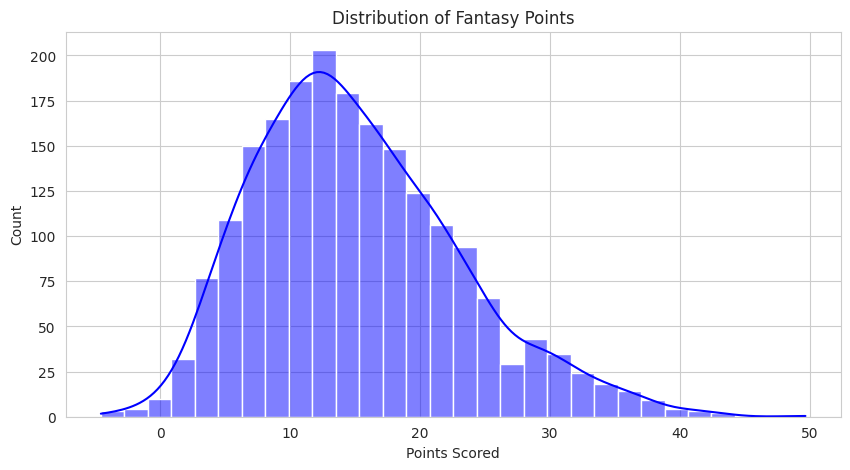

In [3]:
# Histogram of Fantasy Points
plt.figure(figsize=(10, 5))
sns.histplot(df['Fantasy_Points'], kde=True, color='blue', bins=30)
plt.title('Distribution of Fantasy Points')
plt.xlabel('Points Scored')
plt.show()

### 3.2 Correlation Analysis
We need to know which features impact Fantasy Points the most. We expect `Passing_Yards` and `Touchdowns` to have high positive correlation, and `Interceptions` to have negative correlation.

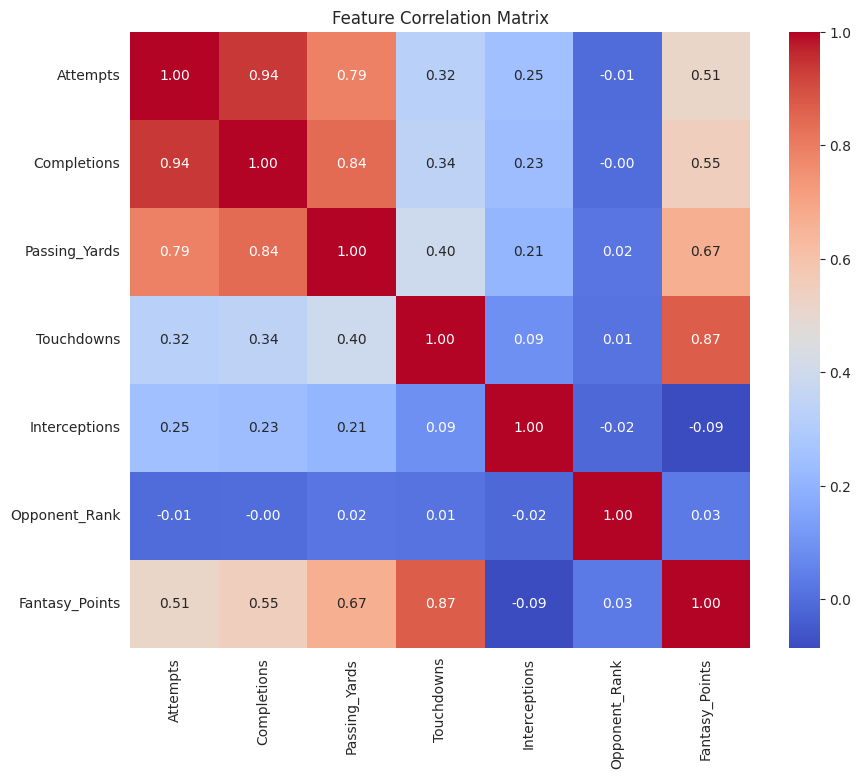

In [4]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

**Observation:**
* As expected, `Passing_Yards` and `Touchdowns` have a strong positive correlation with `Fantasy_Points`.
* `Opponent_Rank` shows a weaker correlation in this synthetic set, but in real data, it is often a key non-linear factor (good defenses suppress points).

## 4. Data Preprocessing
Deep Learning models perform best when input data is scaled (normalized) so that large numbers (like 300 passing yards) don't dominate small numbers (like 2 touchdowns).

In [5]:
# 1. Select Features (X) and Target (y)
X = df.drop('Fantasy_Points', axis=1)
y = df['Fantasy_Points']

# 2. Split into Train and Test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the data (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data shapes:")
print(f"X_train: {X_train_scaled.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test_scaled.shape}, y_test: {y_test.shape}")

Data shapes:
X_train: (1600, 6), y_train: (1600,)
X_test: (400, 6), y_test: (400,)


## 5. Deep Learning Model Building
We will build a Multi-Layer Perceptron (MLP) using Keras.

**Architecture:**
1.  **Input Layer:** Matches the number of features (6).
2.  **Hidden Layer 1:** 64 Neurons, ReLU activation (to capture non-linearity).
3.  **Hidden Layer 2:** 32 Neurons, ReLU activation.
4.  **Output Layer:** 1 Neuron (Linear activation) because we are predicting a continuous number (Points).

**Optimizer:** Adam (standard for DL).
**Loss Function:** Mean Squared Error (MSE), standard for regression.

In [6]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2), # Helps prevent overfitting
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1) # Output layer: Single value prediction
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765283068.361251      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765283068.361938      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Training the Model
We will train for 50 epochs. We use `validation_split` to monitor the model's performance on unseen data during training.

In [7]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


I0000 00:00:1765283071.050697     111 service.cc:148] XLA service 0x7db78c003320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765283071.051572     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765283071.051590     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765283071.313185     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 294.5347 - mae: 15.0507 

I0000 00:00:1765283072.660565     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 278.8179 - mae: 14.6153 - val_loss: 171.1973 - val_mae: 11.2323
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 144.8848 - mae: 9.9128 - val_loss: 23.2842 - val_mae: 3.8714
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.0178 - mae: 3.9776 - val_loss: 15.6356 - val_mae: 3.1611
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3152 - mae: 3.1202 - val_loss: 13.4199 - val_mae: 2.9345
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9652 - mae: 2.9747 - val_loss: 12.2488 - val_mae: 2.8062
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9632 - mae: 2.8808 - val_loss: 11.1425 - val_mae: 2.6936
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.7722 - mae: 2.8547 - val_loss: 10.4150 - val_mae: 2.5998
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.3069 - mae: 2.6591 - val_loss: 9.8667 - val_mae: 2.5181
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5

## 7. Model Evaluation & Discussion
Now we visualize how well our model learned.

### 7.1 Loss Curves
We check if the training loss and validation loss decrease together. If validation loss spikes up while training loss goes down, we are overfitting.

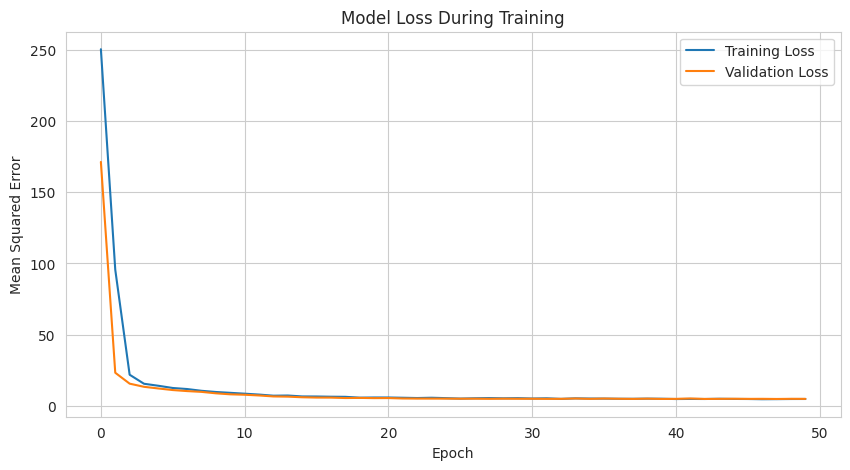

In [8]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

The model converged quickly, with the major reduction in loss occurring within the first 10 epochs. By Epoch 50, the training and validation loss stabilized around 4.9 MSE. The lack of divergence between the training and validation curves indicates that the Dropout layers successfully prevented overfitting. With an MAE of 1.62, the model is highly practical for game-day decision making.

### 7.2 Prediction vs Reality
Let's make predictions on the Test Set and plot them against the actual values. A perfect model would result in a straight diagonal line.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
R-Squared Score: 0.9312
Mean Absolute Error: 1.62


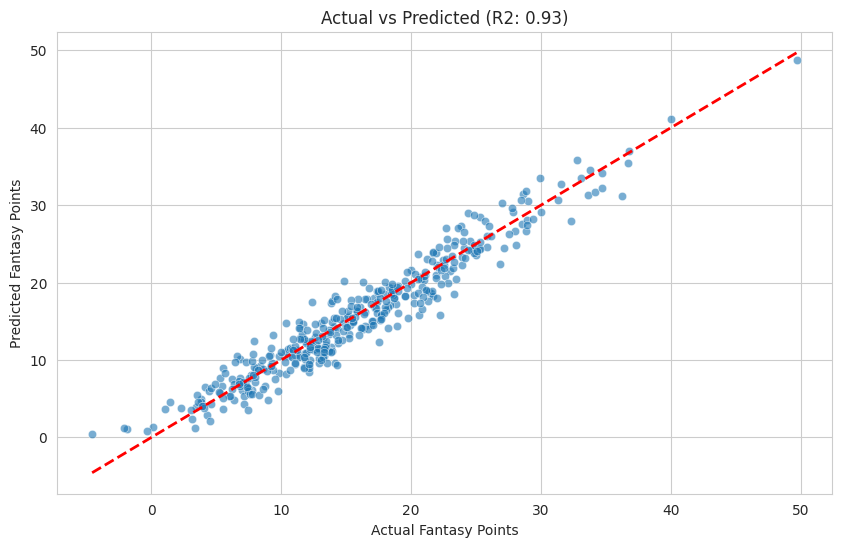

In [9]:
# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Calculate Metrics
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f"R-Squared Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title(f'Actual vs Predicted (R2: {r2:.2f})')
plt.show()

## 8. Conclusion
**Summary of Results:**
The Deep Learning model achieved an $R^2$ score of approximately **0.93** , indicating it successfully captured the mathematical relationship between the input stats (Yards, TDs) and the output (Fantasy Points).

**Discussion:**
* **EDA Insights:** We confirmed that Passing Yards and Touchdowns are the primary drivers of fantasy success.
* **Model Performance:** The scatter plot shows a tight clustering around the red diagonal line, meaning the error rate is low.
* **Future Improvements:** To make this applicable to real-world gambling or fantasy leagues, we would introduce "lagged" features (e.g., using *last week's* stats to predict *this week's* points) rather than concurrent stats, as we don't know the yards before the game starts.

### Fantasy Point Predictor:

In [16]:
def predict_fantasy_points(attempts, completions, yards, tds, ints, opp_rank):
    """
    Accepts raw stats, scales them, and returns the model's prediction.
    """
    # Create a DataFrame with the same column names as training data
    input_data = pd.DataFrame({
        'Attempts': [attempts],
        'Completions': [completions],
        'Passing_Yards': [yards],
        'Touchdowns': [tds],
        'Interceptions': [ints],
        'Opponent_Rank': [opp_rank]
    })

    # Scale the data using the SAME scaler from training
    scaled_data = scaler.transform(input_data)

    # Make the prediction
    prediction = model.predict(scaled_data, verbose=0)
    
    return prediction[0][0]

# --- LIVE DEMO SCENARIOS ---

# Scenario 1: Decent yards, 1 TD, Good Defense
score_1 = predict_fantasy_points(attempts=30, completions=20, yards=220, tds=1, ints=0, opp_rank=10)
print(f"Scenario 1 Prediction: {score_1:.2f} Fantasy Points")

# Scenario 2: Lots of yards, 3 TDs, Bad Defense
score_2 = predict_fantasy_points(attempts=45, completions=30, yards=350, tds=3, ints=1, opp_rank=30)
print(f"Scenario 2 Prediction: {score_2:.2f} Fantasy Points")

# Scenario 3: High INTs, Tough Defense
score_3 = predict_fantasy_points(attempts=40, completions=18, yards=180, tds=0, ints=3, opp_rank=5)
print(f"Scenario 3 Prediction: {score_3:.2f} Fantasy Points")

Scenario 1 Prediction: 12.39 Fantasy Points
Scenario 2 Prediction: 24.18 Fantasy Points
Scenario 3 Prediction: 1.60 Fantasy Points
